In [42]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [43]:
from PIL import Image
m_image = None
im = Image.open("./images/im.jpg") 

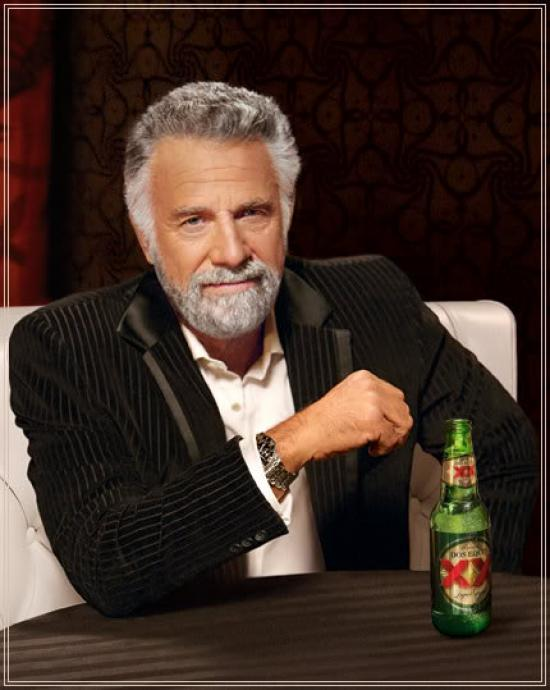

In [44]:
im

In [45]:
arr = np.array(im)

In [46]:
arr.reshape(-1,3).shape

(379500, 3)

In [47]:
# This cell compares different implementations for computing the probabilties of the data 
# Given the hidden components. It serves as a check for correctness of the implementation
# comparing the for loop and a vectorized implementations with scipy's multivariate gauss
# implementation
def diag_gauss_pdf(x, mean, std):
    """
    Returns the probability density function of a diagonal gaussian with mean vector mk
    and std std(number)
    x shape [D]
    mean shape [D]
    std shape [1] 
    
    In EM this would be equal to p(x_n | z_nk = 1)
    """
    exponent = -(x-mean)**2 / (2 * (std**2))
    res = np.exp(exponent) / (np.sqrt(2* np.pi * (std**2)))
    # Product of all dimensions 
    res = np.multiply.reduce(res , axis=-1, initial=1)
    return res

def compute_xn_given_znk(x : np.ndarray , mean , stds):
    """
    Compute all probabilityies p(x_n | z_nk) for every n,k
    Units:
    N : Number of data points 
    D : Features in every data point
    K : Number of classes
    
    Inputs:
    x : data of shape [N,D]
    mean : means of shape [K, D]
    stds: stds of shape [K]
    
    Output:
    p(x_n | z_nk) for every n,k , of shape [N, K]
    """
    D = x.shape[1]
    #print("="*100)
    x = np.expand_dims(x, 1) # [N, K, D]
    exponents = -((x-mean)**2) #[N,K,D]
    exponents = np.sum(exponents, axis=-1) #[N,K]
    exponents /= 2 * (stds ** 2)
    up = np.exp(exponents)
    down = ((2* np.pi * (stds **2)) ** (D/2)) #[N,K,D]
    res = up / down
    #print("res ", res)
    #print("="*100)
    return res

In [48]:
# Tesgting of above function
import math
def sad(x , mean , stds):
    """
    x n,d
    m k,d
    stds k
    """
    N = x.shape[0]
    D = x.shape[1]
    K = mean.shape[0]
    
    output = np.zeros((N,K))
    for i in range(N):
        for j in range(K):
            res = 1
            for jj in range(D):
                res = res * (math.exp(- ((x[i][jj] - mean[j][jj]) ** 2)/ (2 * (std[j]**2))))/(math.sqrt(2*np.pi * std[j]**2))
            output[i][j] = res
    return output
np.random.seed(6)
x = np.random.rand(10, 5)
mean = np.random.rand(3 ,5)
std = np.random.rand(3)
from scipy.stats import multivariate_normal
var = multivariate_normal(mean=mean[0], cov=std[0]*np.eye(5))
def co(x , mean , std):
    N , D = x.shape
    K = mean.shape[0]
    c = np.zeros((N,K))
    for k in range(K):
        var = multivariate_normal(mean=mean[k], cov=(std[k]**2)*np.eye(D))
        for n in range(N):
            c[n,k] = var.pdf(x[n])
    return c
        
#c = co(x ,mean,std)
#c,a,b , mean, std
print("v4 " ,compute_xn_given_znk(x , mean , std))
print("real " , co(x,mean,std))
print("sad " , sad(x,mean,std))
    

v4  [[0.09764411 0.02475429 0.02389324]
 [0.24163143 0.27356666 0.02900698]
 [0.12919645 0.20707242 0.02806959]
 [0.07211467 0.19403576 0.0229382 ]
 [0.02457819 0.04588013 0.01693604]
 [0.0913891  0.08420671 0.01702263]
 [0.10497754 0.11535372 0.02589628]
 [0.13483378 0.05044149 0.03371387]
 [0.13036014 0.33089504 0.01896053]
 [0.12523238 0.11473179 0.01858434]]
real  [[0.09764411 0.02475429 0.02389324]
 [0.24163143 0.27356666 0.02900698]
 [0.12919645 0.20707242 0.02806959]
 [0.07211467 0.19403576 0.0229382 ]
 [0.02457819 0.04588013 0.01693604]
 [0.0913891  0.08420671 0.01702263]
 [0.10497754 0.11535372 0.02589628]
 [0.13483378 0.05044149 0.03371387]
 [0.13036014 0.33089504 0.01896053]
 [0.12523238 0.11473179 0.01858434]]
sad  [[0.09764411 0.02475429 0.02389324]
 [0.24163143 0.27356666 0.02900698]
 [0.12919645 0.20707242 0.02806959]
 [0.07211467 0.19403576 0.0229382 ]
 [0.02457819 0.04588013 0.01693604]
 [0.0913891  0.08420671 0.01702263]
 [0.10497754 0.11535372 0.02589628]
 [0.1348337

In [49]:
def EMAlgorithm(K, data, max_steps):
    """
    Expectation Maximization algorithm
    Inputs:
        data: data of shape (N,D)
        K: the number of classes/components
    Outputs:
        means: the means of the K classes with shape [K,D]
        gammas: the posterior probabilities for every componentn for input data
                with shape [N,K]
    """
    new_gamas = None
    # Initialization
    N = data.shape[0]
    D = data.shape[1]
    # Random prior z probabilities of shape K -> π_κ = p(z_k)
    priors = np.ones(K)
    priors /= np.sum(priors) # These probabilities must sum to one 
    # Random means of shape (K,D)
    #means = np.random.rand(K , D)
    means = np.average(data , axis = 0) + ((np.random.random((K,D)) * 2) -1 )
    # Random stds of shape (D)
    stds = np.random.rand(K) * 10
    previous_log_likelihood = -9999999
    # total steps counter
    total_steps = 0
    #print("data " , data)
    for _ in range(max_steps):
        total_steps +=1
        # Expectation step
        # Compute all joint "probabilities" p(x_n | z_nk)p(z_nk) for every n,k
        xn_given_znk = compute_xn_given_znk(data, means, stds) #[N,K]
        #xn_given_znk = co(data, means, stds) #[N,K]
        joint_probabilities = xn_given_znk * priors
        # Compute p(znk | x) = γ(z_nk)
        gammas = joint_probabilities / \
            np.expand_dims(np.sum(joint_probabilities , axis=-1),axis=-1) # [N,K]
        # Maximization step
        # Compute new means
        # The [..., np.newaxis] means we are appending a dimension with size 1 in the end
        new_means =  (gammas.T @ data )/ (np.sum(gammas, axis=0)[...,np.newaxis]) #[K,D]
        # Compute new stds
        # np.expand_dims(data, 1) # [N, 1,D] - means [K,D] = diffs [N,K,D]
        xminusm = np.expand_dims(data, 1) - new_means# [N, K,D]
        xminusm = np.sum(xminusm ** 2, axis=-1) #[N,K]
        new_stds = np.sqrt(np.sum(gammas * xminusm, axis=0) / (D*(np.sum(gammas, axis=0))))
        # Detect collapses
        for i in range(K):
            if new_stds[i] < 1e-03:
                print("Collapse detected on component" , i)
                means[i] = (np.random.rand(D) * 2) -1
                new_stds[i] = np.random.rand(1) * 10
                #print("new stds " , new_stds)
        # Compute new prior z probs
        new_priors = (np.sum(gammas, axis=0)) / N
        new_priors = new_priors / np.sum(new_priors)
        #normalize priors
        #print("Priors " , new_priors)
        # Updating parameters
        means = new_means
        priors = new_priors
        stds = new_stds
        #Compute new log likelihood
        xn_given_znk = compute_xn_given_znk(data, new_means, stds) #[N,K]
        joint_probabilities = xn_given_znk * priors # [N,K]
        new_gammas = joint_probabilities / \
            np.expand_dims(np.sum(joint_probabilities , axis=-1),axis=-1) # [N,K] 
        new_log_likelihood = np.sum(np.log(np.sum(joint_probabilities, axis=1)), axis=0)
        # Kritirio sigklisis
        if abs(new_log_likelihood - previous_log_likelihood) < 1e-5:
            break
        previous_log_likelihood = new_log_likelihood
        #print("Log likelihood " , new_log_likelihood)
        print(f"Iteration {total_steps} current log likelihood {new_log_likelihood}")
            
    print("EM finished with total steps " , total_steps)
    print("Final LL " , new_log_likelihood)
    print("Final means " , means)
    print("Fianal stds " , stds)
    
    return means, gammas
def compute_log_likelihood(x , means ,stds, priors):
    xn_given_znk = compute_xn_given_znk(x, means, stds) #[N,K]
    #xn_given_znk = co(data, means, stds) #[N,K]
    joint_probabilities = xn_given_znk * priors
    log_likelihood = np.sum(np.log(np.sum(joint_probabilities, axis=1)), axis=0)
    return log_likelihood
    

In [50]:
# Idempotency check
def check_idempotency(func, ins):
    frstout = func(*ins)
    for i in range(5):
        if type(frstout) == np.ndarray:
            assert (func(*ins) == frstout).all()
            
        else:
            assert func(*ins)==frstout
    print("Idempotentcy check for " + str(func) + "passed")
K = 3
N = 10
D = 5
x = np.random.rand(N,D)
means = np.random.rand(K,D)
stds = np.random.rand(K)
priors = np.random.rand(K)
check_idempotency(compute_log_likelihood, [x,means,stds,priors])
check_idempotency(compute_xn_given_znk, [x,means,stds])

Idempotentcy check for <function compute_log_likelihood at 0x7fa1b256df70>passed
Idempotentcy check for <function compute_xn_given_znk at 0x7fa1d94431f0>passed


In [51]:
# Converting image to array
image_array = np.array(im)
original_image_shape = image_array.shape
input_data = image_array.reshape(-1, 3)

In [52]:
# Normalizing input data
X = input_data
avg = np.average(X, axis=0)
std=  np.std(X, axis=0)
X = (X - avg) /std

In [53]:
Ks = [1, 2, 4, 8, 16, 32, 64]
results_k = {}
for k in Ks:
    means, gammas = EMAlgorithm(k, X , 100)
    imarr = means[gammas.argmax(axis=-1)].reshape(original_image_shape)
    selected_pixels = np.uint8(imarr * std + avg)
    results_k[k] = [means, gammas, selected_pixels] 

Iteration 1 current log likelihood -1615461.5200537078
EM finished with total steps  2
Final LL  -1615461.5200537078
Final means  [[ 5.81165916e-16  2.24078405e-15 -4.31920112e-15]]
Fianal stds  [1.]
Iteration 1 current log likelihood -1615919.0244599571
Iteration 2 current log likelihood -1613598.647320105
Iteration 3 current log likelihood -1612576.1601202595
Iteration 4 current log likelihood -1611586.7227510202
Iteration 5 current log likelihood -1610518.4214576532
Iteration 6 current log likelihood -1609374.3050258853
Iteration 7 current log likelihood -1608131.4594849662
Iteration 8 current log likelihood -1606776.381435779
Iteration 9 current log likelihood -1605356.9730495312
Iteration 10 current log likelihood -1603993.0205030849
Iteration 11 current log likelihood -1602830.838412433
Iteration 12 current log likelihood -1601957.5105399338
Iteration 13 current log likelihood -1601359.354322412
Iteration 14 current log likelihood -1600967.072660653
Iteration 15 current log likel

Iteration 63 current log likelihood -141702.08930338497
Iteration 64 current log likelihood -141694.41146716796
Iteration 65 current log likelihood -141687.5991967353
Iteration 66 current log likelihood -141681.5423742856
Iteration 67 current log likelihood -141676.14664840867
Iteration 68 current log likelihood -141671.33091671675
Iteration 69 current log likelihood -141667.0252518031
Iteration 70 current log likelihood -141663.16918529346
Iteration 71 current log likelihood -141659.71028247234
Iteration 72 current log likelihood -141656.60295375244
Iteration 73 current log likelihood -141653.8074600212
Iteration 74 current log likelihood -141651.28907733245
Iteration 75 current log likelihood -141649.0173930882
Iteration 76 current log likelihood -141646.9657110964
Iteration 77 current log likelihood -141645.11054713166
Iteration 78 current log likelihood -141643.431199961
Iteration 79 current log likelihood -141641.9093855143
Iteration 80 current log likelihood -141640.52892404262
I

Iteration 1 current log likelihood -1578256.0286180484
Iteration 2 current log likelihood -1082900.6460286574
Iteration 3 current log likelihood -457715.0706047589
Iteration 4 current log likelihood -257888.15323984443
Iteration 5 current log likelihood -138682.97057225218
Iteration 6 current log likelihood -90401.8569522389
Iteration 7 current log likelihood -59559.66346960114
Iteration 8 current log likelihood -25689.81445201843
Iteration 9 current log likelihood 4782.668161942072
Iteration 10 current log likelihood 21935.78674705428
Iteration 11 current log likelihood 31941.770832888833
Iteration 12 current log likelihood 39825.05766958649
Iteration 13 current log likelihood 46820.99196266336
Iteration 14 current log likelihood 53941.58844515239
Iteration 15 current log likelihood 61109.546796797906
Iteration 16 current log likelihood 68012.27776916114
Iteration 17 current log likelihood 74696.36002801263
Iteration 18 current log likelihood 81471.98177802071
Iteration 19 current log

Iteration 35 current log likelihood 215578.9690449758
Iteration 36 current log likelihood 216236.0532045166
Iteration 37 current log likelihood 216841.610017939
Iteration 38 current log likelihood 217399.14949097615
Iteration 39 current log likelihood 217911.97771398834
Iteration 40 current log likelihood 218383.31815986647
Iteration 41 current log likelihood 218816.30756485942
Iteration 42 current log likelihood 219214.01158483562
Iteration 43 current log likelihood 219579.44706755268
Iteration 44 current log likelihood 219915.56848890794
Iteration 45 current log likelihood 220225.23957126462
Iteration 46 current log likelihood 220511.20255827135
Iteration 47 current log likelihood 220776.0353857142
Iteration 48 current log likelihood 221022.1071936694
Iteration 49 current log likelihood 221251.555005669
Iteration 50 current log likelihood 221466.29235113203
Iteration 51 current log likelihood 221668.04540331048
Iteration 52 current log likelihood 221858.40364326152
Iteration 53 curre

Iteration 55 current log likelihood 368188.20373443846
Iteration 56 current log likelihood 369576.2536481477
Iteration 57 current log likelihood 370699.48834791756
Iteration 58 current log likelihood 371612.9248126644
Iteration 59 current log likelihood 372371.1667031445
Iteration 60 current log likelihood 373020.03602619853
Iteration 61 current log likelihood 373595.62507212535
Iteration 62 current log likelihood 374125.5303476095
Iteration 63 current log likelihood 374630.52328232833
Iteration 64 current log likelihood 375125.26945964916
Iteration 65 current log likelihood 375617.6030767759
Iteration 66 current log likelihood 376108.3866473097
Iteration 67 current log likelihood 376594.5566071856
Iteration 68 current log likelihood 377073.3200312718
Iteration 69 current log likelihood 377543.6022659277
Iteration 70 current log likelihood 378005.1133672532
Iteration 71 current log likelihood 378457.24001360714
Iteration 72 current log likelihood 378898.5921787957
Iteration 73 current 

In [54]:
# Compute error from a segmented image
def compute_error(imarr):
    difs = imarr.astype("float64") - np.array(im).astype("float64")
    difs = difs ** 2
    return np.sum(difs) / (difs.shape[0] * difs.shape[1])

In [55]:
# Convert from image to PIL
def numpy2pil(np_array: np.ndarray) -> Image:
    """
    Convert an HxWx3 numpy array into an RGB Image
    """

    assert_msg = 'Input shall be a HxWx3 ndarray'
    assert isinstance(np_array, np.ndarray), assert_msg
    assert len(np_array.shape) == 3, assert_msg
    assert np_array.shape[2] == 3, assert_msg

    img = Image.fromarray(np_array, 'RGB')
    return img

In [56]:
# Errors for every k=
errors = {}
for k in results_k:
    errors[k] = compute_error(results_k[k][2])
errors

{1: 11360.973459815546,
 2: 3105.708700922266,
 4: 1096.8389934123848,
 8: 501.19132279314886,
 16: 328.31858761528326,
 32: 172.16989459815548,
 64: 106.43423188405797}

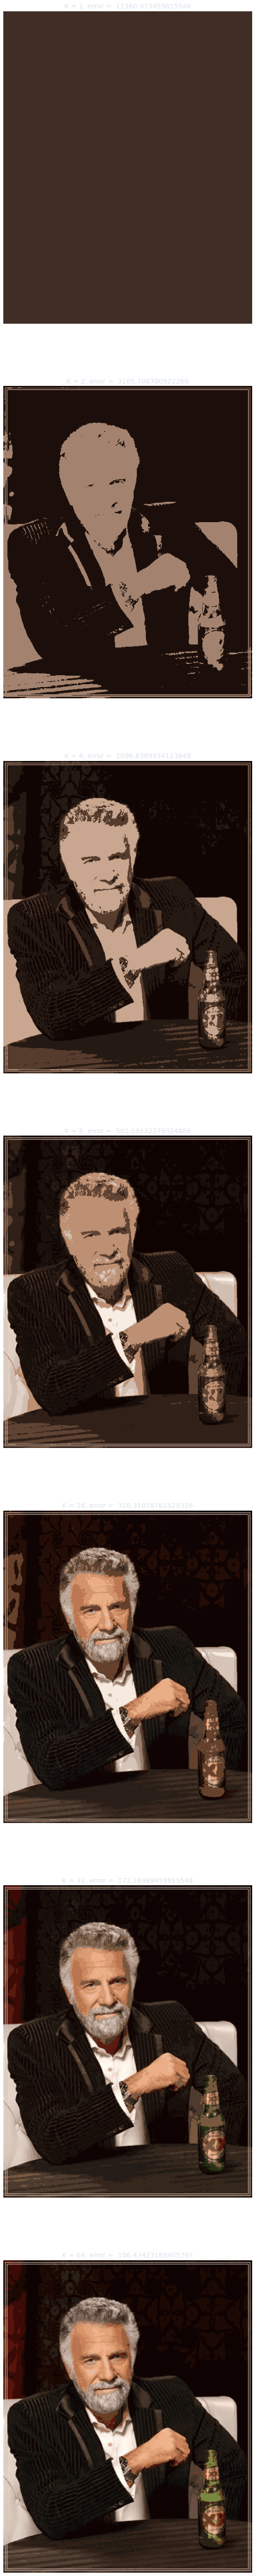

In [57]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(len(results_k) ,figsize=(20,100))
for i,k in enumerate(results_k):
    axs[i].grid(False)
    axs[i].axis('off')
    axs[i].imshow(numpy2pil(results_k[k][2]))
    axs[i].set_title(f"K = {k}, error =  {errors[k]}")
    